In [1]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [2]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph-Structures")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph-Structures]


## 웹 검색 모듈 추가

03.LangGraph-Add-Groundedness-Check.ipynb 에서 이어서 진행합니다.  
  
03.LangGraph-Add-Groundedness-Check.ipynb 에서 관령성 체크 실패시 다시 문서를 검색하는 것이 아니라 웹 검색을 통해 정보를 찾는 것을 구현합니다.
  
##### 그래프 흐름

![langgraph_structures_web_search.png](./assets/langgraph_structures_add_web_search.png)

In [3]:
from rag.pdf import PDFRetrievalChain

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


# PDF 문서 검색 체인 생성, 체인 안에는 llm 이 포함되어 있음
pdf = PDFRetrievalChain(
    source_uri=["./data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf"]
).create_chain()

pdf_retriever = pdf.retriever
pdf_chain = pdf.chain


# 그래프 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[list, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적)
    relevance: Annotated[bool, "Relevance"]  # 관련성 체크

In [4]:
from langchain_openai import ChatOpenAI
from evaluators import GroundednessChecker
from langchain_print import messages_to_history
from rag.utils import format_docs


# 노드 정의
# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    latest_question = state["question"]
    retrieved_docs = pdf_retriever.invoke(latest_question)
    retrieved_docs_formatted = format_docs(retrieved_docs)

    return GraphState(context=retrieved_docs_formatted)


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 마지막 질문 추출
    latest_question = state["question"]
    # 검색된 문서 추출
    context = state["context"]

    # 답변 생성
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )

    return GraphState(
        answer=response, messages=[("user", latest_question), ("assistant", response)]
    )


# 관령성 체크 노드
def relevance_check(state: GraphState) -> GraphState:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    # 검색된 문서와 관련성 평가 생성
    # question-retrieval - 모드는 검색된 문서가 질문과 관련이 있는지 평가
    checker = GroundednessChecker(llm=llm, target="question-retrieval")
    evaluator = checker.create()

    response = evaluator.invoke(
        {
            "question": state["question"],  # 질문
            "context": state["context"],  # 문서의 검색 결과
        }
    )

    print("==== [Relevance Check] ====")
    print(response.score)

    return {"relevance": response.score}


# 관련성 체크 결과에 따라 체크 결과를 반환하는 노드
def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"

웹 검색 노드를 추가합니다.

In [10]:
from tools_tavily import TavilySearch


def web_search(state: GraphState) -> GraphState:
    tavily_tool = TavilySearch()
    search_query = state["question"]

    search_results = tavily_tool.invoke(
        input=search_query,  # 검색 쿼리
        topic="general",  # 주제
        max_results=5,  # 최대 검색 결과 수
        format_output=True,  # 결과 포매팅
    )

    return GraphState(context=search_results)

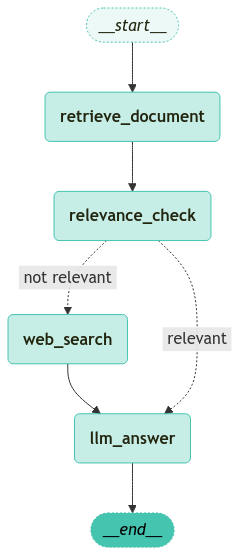

In [11]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from graphs import visualize_graph

# 그래프 정의 및 엣지 설정
workflow = StateGraph(GraphState)

# 노드 및 엣지 설정
workflow.add_node("retrieve_document", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)
# 웹검색 노드 추가
workflow.add_node("web_search", web_search)

workflow.add_edge("retrieve_document", "relevance_check")

# 조건부 노드 추가
workflow.add_conditional_edges(
    "relevance_check",
    is_relevant,
    {"relevant": "llm_answer", "not relevant": "web_search"},
)


workflow.add_edge("web_search", "llm_answer")
workflow.add_edge("llm_answer", END)

# 시작 노드 설정
workflow.set_entry_point("retrieve_document")

# 메모리 설정
memory = MemorySaver()

# 그래프 생성
app = workflow.compile(checkpointer=memory)

# 그래프 시각화
visualize_graph(app)

In [12]:
from langchain_core.runnables import RunnableConfig
from langchain_print import stream_graph, invoke_graph, random_uuid

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

inputs = GraphState(
    question="Who will win the 2024 Nobel Prize in Literature? Please answer in Korean."
)

invoke_graph(app, inputs, config, ["retrieve_document", "web_search", "llm_answer"])


🔄 Node: retrieve_document 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [Relevance Check] ====
no

🔄 Node: web_search 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{'title': '[K-Lit] Han Kang (한강): 2024 Nobel Prize Winner in Literature', 'url': 'https://koreancultureblog.com/2024/10/13/k-lit-han-kang-한강-2024-nobel-prize-winner-in-literature/', 'content': 'Congratulations to Korean novelist and poet Han Kang (한강) for winning the 2024 Nobel Prize in Literature! In 2016, Han became the first Korean writer to win the Man Booker International Prize for this work, alongside translator Deborah Smith. Han’s recognition as a Nobel laureate not only highlights Han’s literary achievements but also signifies the growing global influence of Korean culture, following the footsteps of director Bong Joon-ho’s Oscar-winning K-movie Parasite, the global success of K-drama Squid Game, and the international popularity of K-pop groups like BTS and BLACKPINK. Kim Tong-hyung, “South Korea

In [13]:
stream_graph(app, inputs, config, ["retrieve_document", "web_search", "llm_answer"])

==== [Relevance Check] ====
no

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
2024년 노벨 문학상 수상자는 한강입니다.

**Source**
- [K-Lit] Han Kang (한강): 2024 Nobel Prize Winner in Literature (https://koreancultureblog.com/2024/10/13/k-lit-han-kang-한강-2024-nobel-prize-winner-in-literature/)

In [14]:
# get_state 는 그래프의 현재 상태를 가져옴
outputs = app.get_state(config).values

# 현재 상태의 질문을 출력
print(f'Question: {outputs["question"]}')
print("===" * 20)
# 현재 상태의 답변을 출력
print(f'Answer:\n{outputs["answer"]}')

Question: Who will win the 2024 Nobel Prize in Literature? Please answer in Korean.
Answer:
2024년 노벨 문학상 수상자는 한강입니다.

**Source**
- [K-Lit] Han Kang (한강): 2024 Nobel Prize Winner in Literature (https://koreancultureblog.com/2024/10/13/k-lit-han-kang-한강-2024-nobel-prize-winner-in-literature/)
